In [3]:
# scikit version


In [4]:
from utilities import *
from os.path import expanduser

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
path = expanduser('~/data/Women Dresses Reviews Dataset .csv')
data = pd.read_csv(path)

In [6]:
# data.rating.info(), print(), data.review_text.info()

In [7]:
data['review_text'] = data['review_text'].fillna('')

data['cleaned_review'] = data['review_text']\
    .apply(lambda x: tokenize(x))\
    .apply(lambda x: create_stemwords(x))

# sklearn throws an error if the data isn't string
data['cleaned_review_JOINED'] = data['cleaned_review'].apply(lambda x: ' '.join(x))

data.head()

,s.no,age,division_name,department_name,class_name,clothing_id,title,review_text,alike_feedback_count,rating,recommend_index,cleaned_review,cleaned_review_JOINED
0,0,40,General,Bottoms,Jeans,1028,Amazing fit and wash,Like other reviewers i was hesitant to spend t...,0,5,1,"[like, review, hesit, spend, pair, jean, purch...",like review hesit spend pair jean purchas reta...
1,1,62,General Petite,Tops,Blouses,850,Lovely and unique!,As is true of a bunch of the fall clothing pho...,12,5,1,"[true, bunch, fall, cloth, photo, color, total...",true bunch fall cloth photo color total wash m...
2,2,47,General Petite,Bottoms,Skirts,993,Meh,"I so wanted this skirt to work, love the desig...",3,1,0,"[want, skirt, work, love, design, way, way, lo...",want skirt work love design way way long small...
3,3,45,General Petite,Bottoms,Pants,1068,Wow,Love love this! i was hesitant to buy this at ...,0,5,1,"[love, love, hesit, buy, review, big, wasn, su...",love love hesit buy review big wasn sure kind ...
4,4,37,Initmates,Intimate,Swim,24,Great for bigger busts,I absolutely love the retro look of this swims...,0,5,1,"[absolut, love, retro, look, swimsuit, saw, bl...",absolut love retro look swimsuit saw blogger a...


In [8]:
X = data['cleaned_review_JOINED']
y = data['rating']

# LOGISTIC REGRESSION

In [9]:
# encode the target variable for yellowbrick
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
from sklearn.utils import compute_class_weight

classes = np.unique(y)
weights = compute_class_weight(
    class_weight='balanced', classes=classes, y=y
)

class_weights = dict(zip(classes, weights))

In [24]:
logreg_params = {'C': 10,
                 'class_weight': class_weights,
                 'solver': 'saga',
                 'penalty': 'l2',
                 'multi_class': 'multinomial',
                 'random_state': 42,
                 'max_iter': 1000}

tfidf_params = {'smooth_idf': True,
                'max_df': 0.5}

# Scale if using regularization
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
   # ('preprocess', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(**logreg_params))]
    )

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.23      0.44      0.30       168
           1       0.22      0.05      0.08       313
           2       0.32      0.37      0.35       574
           3       0.37      0.41      0.39      1016
           4       0.79      0.75      0.77      2627

    accuracy                           0.57      4698
   macro avg       0.39      0.40      0.38      4698
weighted avg       0.58      0.57      0.57      4698


/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'logreg__C': [0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')

# Fit on data
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best parameters: {'logreg__C': 0.1, 'tfidf__max_df': 0.5}
Best cross-validation score: 0.5704244638906046


In [1]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X, y, scoring='f1_weighted') 
print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())


from sklearn.model_selection import cross_validate

scores = cross_validate(
    pipeline, X, y, scoring=('precision', 'recall', 'f1_weight'), return_train_score=True)

NameError: name 'pipeline' is not defined

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'logreg__C': [0.1, 1, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3)

# Fit on data
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best parameters: {'logreg__C': 1, 'tfidf__max_df': 0.5}
Best cross-validation score: 0.5671044032468934


/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/witcheverly/opt/anaconda3/envs/mle/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

0.6003462786768974

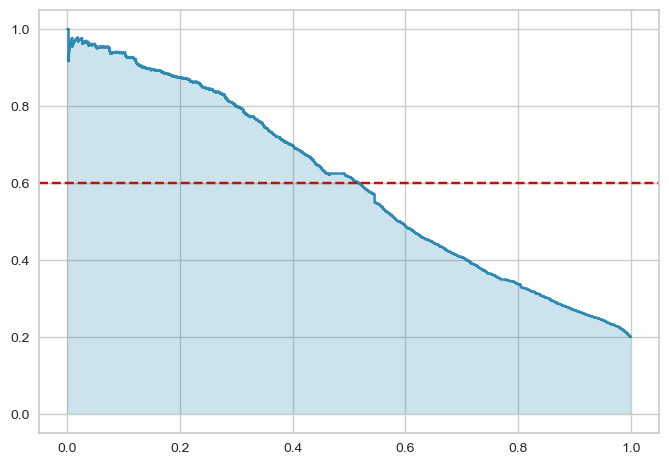

In [21]:
# yellowbrick precision recall curve
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(pipeline)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)

# LOGISTIC REGRESSION CV

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# import cross validation score
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate


In [11]:
lr_cv = LogisticRegressionCV(
    Cs=10,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=1,
    multi_class='auto',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_cv.fit(X_train, y_train)
predictions = lr_cv.predict(X_test)
print(classification_report(y_test, predictions))

NameError: name 'LogisticRegressionCV' is not defined